In [20]:
import findspark
findspark.init()
from pyspark import SparkContext
sc=SparkContext()
sc

<SparkContext master=yarn appName=pyspark-shell>

In [21]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.getOrCreate()
spark

In [41]:
dataset = spark.read.option("header", "true").csv("s3://open-data-noaa/M425/*.csv")

In [43]:
dataset=dataset.dropna()

In [44]:
dataset.columns[:]
#['avg(liquid)','avg(latitude)','avg(dew)','avg(vis)','avg(longitude)','avg(wind)','avg(elevation)','avg(temp)','avg(cig)','avg(slp)']

['avg(liquid)',
 'avg(latitude)',
 'avg(dew)',
 'avg(vis)',
 'avg(longitude)',
 'avg(wind)',
 'avg(elevation)',
 'avg(temp)',
 'avg(cig)',
 'avg(slp)']

In [ ]:
from pyspark.sql import functions
data_converted = dataset.select(*(functions.col(col).cast("float").alias(col) for col in data.columns))

In [49]:
#Convert Type
colname_float = ['avg(liquid)','avg(latitude)','avg(dew)','avg(vis)','avg(longitude)','avg(wind)','avg(elevation)','avg(cig)','avg(slp)']
#colname_timestamp = ["pickup_datetime","dropoff_datetime"]
data_converted = dataset.withColumn("temp", dataset['avg(temp)'].cast("float"))
for i in colname_float:
    data_converted = data_converted.withColumn(i, data_converted[i].cast("float"))
data_converted=data_converted.drop('avg(temp)')

In [50]:
data_converted.printSchema()

root
 |-- avg(liquid): float (nullable = true)
 |-- avg(latitude): float (nullable = true)
 |-- avg(dew): float (nullable = true)
 |-- avg(vis): float (nullable = true)
 |-- avg(longitude): float (nullable = true)
 |-- avg(wind): float (nullable = true)
 |-- avg(elevation): float (nullable = true)
 |-- avg(cig): float (nullable = true)
 |-- avg(slp): float (nullable = true)
 |-- temp: float (nullable = true)



In [51]:
vectorAssembler = VectorAssembler(inputCols = ['avg(liquid)','avg(latitude)','avg(dew)','avg(vis)','avg(longitude)','avg(wind)','avg(elevation)','avg(cig)','avg(slp)'], outputCol = 'features')
data2 = vectorAssembler.transform(data_converted)
data2= data2.select(['features', 'temp'])
data2.printSchema()

root
 |-- features: vector (nullable = true)
 |-- temp: float (nullable = true)



In [89]:
#rename
data_re=data_converted
data_re = data_re.withColumnRenamed("avg(latitude)","latitude")
data_re = data_re.withColumnRenamed("avg(liquid)","liquid")
data_re = data_re.withColumnRenamed("avg(dew)","dew")
data_re = data_re.withColumnRenamed("avg(vis)","vis")
data_re = data_re.withColumnRenamed("avg(longitude)","longitude")
data_re = data_re.withColumnRenamed("avg(wind)","wind")
data_re = data_re.withColumnRenamed("avg(elevation)","elevation")
data_re = data_re.withColumnRenamed("avg(cig)","cig")
data_re = data_re.withColumnRenamed("avg(slp)","slp")

In [90]:
data_re.printSchema()

root
 |-- liquid: float (nullable = true)
 |-- latitude: float (nullable = true)
 |-- dew: float (nullable = true)
 |-- vis: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- wind: float (nullable = true)
 |-- elevation: float (nullable = true)
 |-- cig: float (nullable = true)
 |-- slp: float (nullable = true)
 |-- temp: float (nullable = true)



In [56]:
splitted_data2 = data2.randomSplit([0.7, 0.3], 24)
train_data = splitted_data2[0]
test_data = splitted_data2[1]

In [55]:
print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))

Number of training records: 4706
Number of testing records : 2004


## GeneralizedLinearRegression

### Gaussian Kernel

In [57]:
from pyspark.ml.regression import GeneralizedLinearRegression
glr_gau = GeneralizedLinearRegression(featuresCol = 'features', labelCol='temp',family="gaussian", link="identity", maxIter=10, regParam=0.3)
glr_gau_model = glr.fit(train_data)

In [295]:
display(glr_gau_model, train_data)

GeneralizedLinearRegression_1bf4b11c83e2

DataFrame[features: vector, temp: float]

In [58]:
# Print the coefficients and intercept for generalized linear regression model
print("Coefficients: " + str(glr_gau_model.coefficients))
print("Intercept: " + str(glr_gau_model.intercept))

Coefficients: [-0.11093365112114201,-0.02187144870458695,0.9040932315193124,6.080485487610647e-06,-0.0013187146575069455,0.14733977391867567,0.0017494436934658627,0.00021359117407379412,-0.03817432137470207]
Intercept: 41.66770869022594


In [59]:
glr_gau_pre = glr_gau_model.transform(test_data)

In [60]:
glr_gau_pre_rdd=glr_gau_pre['temp', 'prediction'].rdd
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.mllib.linalg import DenseVector
glr_gau_metrics = RegressionMetrics(glr_gau_pre_rdd)
# Squared Error
print("MSE = %s" % glr_gau_metrics.meanSquaredError)
print("RMSE = %s" % glr_gau_metrics.rootMeanSquaredError)
# R-squared
print("R-squared = %s" % glr_gau_metrics.r2)
# Mean absolute error
print("MAE = %s" % glr_gau_metrics.meanAbsoluteError)
# Explained variance
print("Explained variance = %s" % glr_gau_metrics.explainedVariance)

MSE = 8.922409086154898
RMSE = 2.987040188239003
R-squared = 0.890627695576554
MAE = 1.9028022182776645
Explained variance = 94.47879596032428


In [70]:
summary = glr_gau_model.summary
print("Coefficient Standard Errors: " + str(summary.coefficientStandardErrors))
print("T Values: " + str(summary.tValues))
print("P Values: " + str(summary.pValues))
print("Dispersion: " + str(summary.dispersion))
print("Null Deviance: " + str(summary.nullDeviance))
print("Residual Degree Of Freedom Null: " + str(summary.residualDegreeOfFreedomNull))
print("Deviance: " + str(summary.deviance))
print("Residual Degree Of Freedom: " + str(summary.residualDegreeOfFreedom))
print("AIC: " + str(summary.aic))
print("Deviance Residuals: ")
summary.residuals().show()

Coefficient Standard Errors: [0.03224761133657079, 0.002138487450511991, 0.006174357807108475, 4.602351558485996e-06, 0.0005294920195455234, 0.02737233230912191, 9.190576866484469e-05, 6.394964576364493e-06, 0.008561594428787029, 8.69528947767844]
T Values: [-3.44005793059582, -10.22753194055478, 146.42708760390258, 1.3211692784309816, -2.49052791888881, 5.3827993995810965, 19.03518918214598, 33.399899487046056, -4.458786466963076, 4.791986373448585]
P Values: [0.0005866542075205761, 0.0, 0.0, 0.1865092966257973, 0.012789644346421936, 7.690720349451396e-08, 0.0, 0.0, 8.434753577590826e-06, 1.7023210379107923e-06]
Dispersion: 8.652176299976487
Null Deviance: 440368.3367260571
Residual Degree Of Freedom Null: 4705
Deviance: 40630.61990468957
Residual Degree Of Freedom: 4696
AIC: 23521.696857978994
Deviance Residuals: 
+-------------------+
|  devianceResiduals|
+-------------------+
| -4.477047558777983|
| 2.9121189413050104|
| 1.0651538492001507|
| -0.977898910060496|
|-1.58246015035362

/usr/lib/spark/python/pyspark/sql/dataframe.py:2103: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


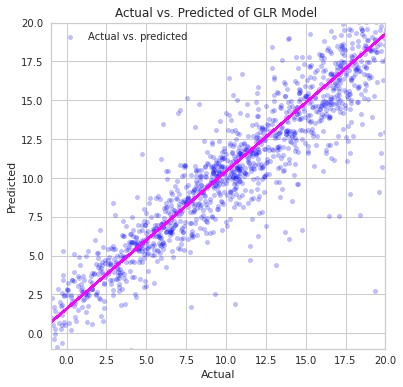

In [272]:
import numpy as np
glr_gau_pre2 = glr_gau_pre.select("*").toPandas()

ax = glr_gau_pre2.plot(kind='scatter', figsize = (6,6), x='temp', y='prediction', color='blue', alpha = 0.25, label='Actual vs. predicted');
fit = np.polyfit(glr_gau_pre2['temp'], glr_gau_pre2['prediction'], deg=1)
ax.set_title('Actual vs. Predicted of GLR Model ')
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.plot(glr_gau_pre2['temp'], fit[0] * glr_gau_pre2['temp'] + fit[1], color='magenta')
plt.axis([-1, 20, -1, 20])
plt.show(ax)

Text(0, 0.5, 'Residuals')

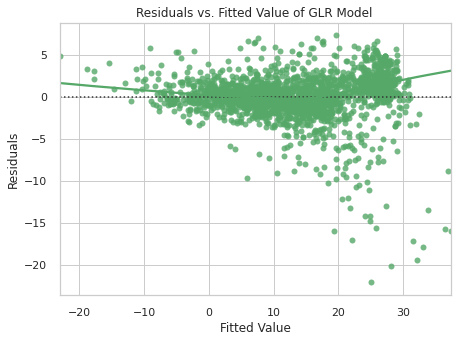

In [294]:
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt
f,ax =  plt.subplots(figsize = (7, 5))
sns.set(style="whitegrid")
sns.residplot(glr_gau_pre2['temp'], glr_gau_pre2['prediction'], lowess=True, color="g")

ax.set_title('Residuals vs. Fitted Value of GLR Model ')
ax.set_xlabel("Fitted Value")
ax.set_ylabel("Residuals")

In [200]:
summary.residuals().count()

4706

In [209]:
glr_gau_pre.show(2)

+--------------------+---------+-----------------+
|            features|     temp|       prediction|
+--------------------+---------+-----------------+
|[0.0,-20.29999923...|28.866667|30.72364722223364|
|[0.0,30.983333587...|2.1642857|1.098770169985663|
+--------------------+---------+-----------------+
only showing top 2 rows



In [211]:
glr_gau_result=glr_gau_pre.select('temp','prediction')
glr_gau_result = glr_gau_result.withColumnRenamed("temp","true_temp")
glr_gau_result= glr_gau_result.withColumnRenamed("prediction","pred_temp")

In [219]:
glr_gau_result=glr_gau_result.withColumn("residual", glr_gau_result.true_temp-glr_gau_result.pred_temp )

In [220]:
glr_gau_result.show(2)

+---------+-----------------+-------------------+
|true_temp|        pred_temp|           residual|
+---------+-----------------+-------------------+
|28.866667|30.72364722223364|-1.8569804284103988|
|2.1642857|1.098770169985663| 1.0655154898043762|
+---------+-----------------+-------------------+
only showing top 2 rows



In [221]:
glr_gau_result.write.csv("s3://open-data-noaa/modelresult/glr", sep=',', header=True,mode="overwrite")

In [240]:
glr_gau_model

GeneralizedLinearRegression_1bf4b11c83e2

## Isotonic regression 

In [71]:
from pyspark.ml.regression import IsotonicRegression

In [72]:
ir = IsotonicRegression(featuresCol = 'features', labelCol='temp')
ir_model = ir.fit(train_data)

In [73]:
print("Boundaries in increasing order: %s\n" % str(ir_model.boundaries))
print("Predictions associated with the boundaries: %s\n" % str(ir_model.predictions))
ir_pre = ir_model.transform(test_data)

Boundaries in increasing order: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03333333507180214,0.03333333507180214,0.049841269850730896,0.04990079253911972,0.12389937043190002,0.1240740716457367,0.12812499701976776,0.12812761962413788,0.1325751692056656,0.1325863003730774,0.14987391233444214,0.14991334080696106,0.15409165620803833,0.15424774587154388,0.23797114193439484,0.23799127340316772,0.2567131519317627,0.2569211423397064,0.2622460126876831,0.2623441517353058,0.33047839999198914,0.33066239953041077,0.3331901431083679,0.3333333432674408,0.4958227872848511,0.4962962865829468,0.5319122076034546,0.5319716334342957,0.6222222447395325,0.6230158805847168,0.7076727747917175,0.7085069417953491,0.8391477465629578,0.841005265712738,1.0779072046279907,1.077971339225769,1.2083333730697632,1.2103283405303955,9.471428871154785,10.33333301544189

/usr/lib/spark/python/pyspark/sql/dataframe.py:2103: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


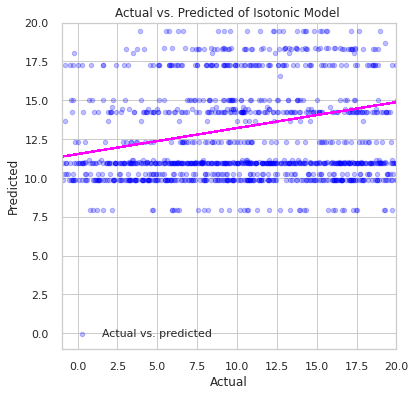

In [297]:
import numpy as np
ir_pre2 = ir_pre.select("*").toPandas()

ax = ir_pre2.plot(kind='scatter', figsize = (6,6), x='temp', y='prediction', color='blue', alpha = 0.25, label='Actual vs. predicted');
fit = np.polyfit(ir_pre2['temp'], ir_pre2['prediction'], deg=1)
ax.set_title('Actual vs. Predicted of Isotonic Model ')
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.plot(ir_pre2['temp'], fit[0] * ir_pre2['temp'] + fit[1], color='magenta')
plt.axis([-1, 20, -1, 20])
plt.show(ax)

Text(0, 0.5, 'Residuals')

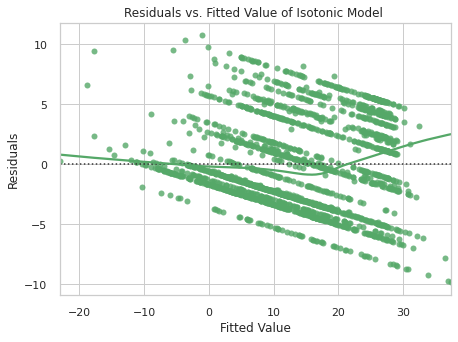

In [298]:
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt
f,ax =  plt.subplots(figsize = (7, 5))
sns.set(style="whitegrid")
sns.residplot(ir_pre2['temp'], ir_pre2['prediction'], lowess=True, color="g")

ax.set_title('Residuals vs. Fitted Value of Isotonic Model ')
ax.set_xlabel("Fitted Value")
ax.set_ylabel("Residuals")

In [75]:
ir_pre_rdd=ir_pre['temp', 'prediction'].rdd
ir_metrics = RegressionMetrics(ir_pre_rdd)
# Squared Error
print("MSE = %s" % ir_metrics.meanSquaredError)
print("RMSE = %s" % ir_metrics.rootMeanSquaredError)
# R-squared
print("R-squared = %s" % ir_metrics.r2)
# Mean absolute error
print("MAE = %s" % ir_metrics.meanAbsoluteError)
# Explained variance
print("Explained variance = %s" % ir_metrics.explainedVariance)

MSE = 79.08168977240922
RMSE = 8.892788638689735
R-squared = -3.8786590148816105
MAE = 7.318951753794693
Explained variance = 94.4838114726816


## PCA

In [110]:
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline, Model
from pyspark.ml.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.util import MLUtils
import numpy as np
from pyspark.ml.feature import StandardScaler
import pyspark.sql.functions as f
import pyspark.sql.types
import pandas as pd

In [105]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=False, withMean=True)

In [106]:
scalerModel = scaler.fit(data2)

In [107]:
scaledData = scalerModel.transform(data2)
scaledData.select(['temp', 'scaledFeatures']).show(5, truncate = False) 

+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|temp     |scaledFeatures                                                                                                                                                                   |
+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|9.777019 |[-0.35313151625168987,15.870668972664461,0.7396950672681637,-15687.966668440795,-18.711708140785802,-1.131107605796934,-190.20084235310208,-11542.018309062498,9.071031659690675]|
|19.862823|[-0.32902784680200287,-4.759589587516203,5.825257773261816,-2150.566613509154,-112.61006934684049,2.518722497123598,-217.97083899616848,-2637.596495097654,0.911485761253175]    |
|8.011511 |[-0.18858039786291786,7.468493069344149

In [111]:
pca = PCA(k=3, inputCol = scaler.getOutputCol(), outputCol="pcaFeatures")
pca_model = pca.fit(scaledData)

In [319]:
transformed_feature = pca_model.transform(scaledData)
transformed_feature.show(2)

+--------------------+---------+--------------------+--------------------+
|            features|     temp|      scaledFeatures|         pcaFeatures|
+--------------------+---------+--------------------+--------------------+
|[0.02650103531777...| 9.777019|[-0.3531315162516...|[-18733.795705999...|
|[0.05060470476746...|19.862823|[-0.3290278468020...|[-2938.3807440136...|
+--------------------+---------+--------------------+--------------------+
only showing top 2 rows



In [251]:
transformed_feature.select('pcaFeatures').show(2,truncate = False)

+----------------------------------------------------------+
|pcaFeatures                                               |
+----------------------------------------------------------+
|[-18733.795705999226,5330.084806861207,41.022077640356265]|
|[-2938.38074401365,1720.6543243202714,187.89095988992244] |
+----------------------------------------------------------+
only showing top 2 rows



**Variance Explained by each PC**

In [113]:
np.round(100*pca_model.explainedVariance.toArray(),3)

array([72.316, 27.531,  0.149])

In [114]:
pcs = np.round(pca_model.pc.toArray(),4)
pcs

array([[-0.000e+00,  0.000e+00, -0.000e+00],
       [ 5.000e-04,  5.000e-04, -7.000e-04],
       [-3.000e-04, -1.000e-04,  5.400e-03],
       [ 9.369e-01,  3.496e-01,  3.900e-03],
       [ 1.300e-03, -1.200e-03,  1.490e-02],
       [ 0.000e+00,  0.000e+00,  0.000e+00],
       [ 6.300e-03, -5.800e-03, -9.998e-01],
       [ 3.496e-01, -9.369e-01,  7.600e-03],
       [ 1.000e-04, -1.000e-04, -1.600e-03]])

In [115]:
cols = data_re.drop('temp').columns
cols

['liquid',
 'latitude',
 'dew',
 'vis',
 'longitude',
 'wind',
 'elevation',
 'cig',
 'slp']

In [117]:
pcs = np.round(pca_model.pc.toArray(),5)
df_pc = pd.DataFrame(pcs, columns = ['PC1','PC2','PC3'], index = cols)
df_pc

PC1      PC2      PC3
liquid    -0.00001  0.00002 -0.00001
latitude   0.00048  0.00053 -0.00074
dew       -0.00034 -0.00008  0.00543
vis        0.93689  0.34960  0.00391
longitude  0.00127 -0.00117  0.01488
wind       0.00001  0.00005  0.00003
elevation  0.00633 -0.00575 -0.99984
cig        0.34956 -0.93688  0.00758
slp        0.00007 -0.00014 -0.00165

In [119]:
df_pc['PC1']

liquid      -0.00001
latitude     0.00048
dew         -0.00034
vis          0.93689
longitude    0.00127
wind         0.00001
elevation    0.00633
cig          0.34956
slp          0.00007
Name: PC1, dtype: float64

In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.preprocessing import scale
%matplotlib inline

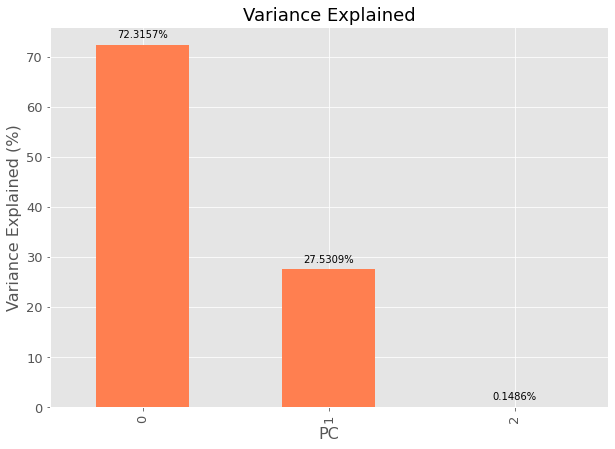

In [149]:
var = pd.DataFrame ({'variance':np.round(100*pca_model.explainedVariance.toArray(),4), 
                    'PC':['p' + str(i) for i in range(1,4)]})

ax = var.plot(kind='bar', figsize=(10,7), color="coral", fontsize=13, legend = False)
ax.set_alpha(0.8)
ax.set_title("Variance Explained", fontsize=18)
ax.set_xlabel("PC", fontsize=16)
ax.set_ylabel("Variance Explained (%)", fontsize=16)

rects = ax.patches
labels = list(var['variance'])
labels = [str(variance) +'%' for variance in labels]
                          

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1, label,
            ha ='center', va='bottom')

In [372]:
pf=transformed_feature.select("pcaFeatures","temp")

In [375]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, DoubleType
def to_array(col):
    def to_array_(v):
        return v.toArray().tolist()
    # Important: asNondeterministic requires Spark 2.3 or later
    # It can be safely removed i.e.
    # return udf(to_array_, ArrayType(DoubleType()))(col)
    # but at the cost of decreased performance
    return udf(to_array_, ArrayType(DoubleType())).asNondeterministic()(col)
(pf
    .withColumn("pcaFeatures", to_array(col("pcaFeatures")))
     .select(["temp"] + [col("pcaFeatures")[i] for i in range(3)]))

DataFrame[temp: float, pcaFeatures[0]: double, pcaFeatures[1]: double, pcaFeatures[2]: double]

In [377]:
pf1=pf.withColumn("pcaFeatures", to_array(col("pcaFeatures"))).select(["temp"] + [col("pcaFeatures")[i] for i in range(3)])

In [379]:
pf1 = pf1.withColumnRenamed("pcaFeatures[0]","PC1")
pf1 = pf1.withColumnRenamed("pcaFeatures[1]","PC2")
pf1 = pf1.withColumnRenamed("pcaFeatures[2]","PC3")

In [380]:
pf1.show(2)

+---------+-------------------+------------------+------------------+
|     temp|                PC1|               PC2|               PC3|
+---------+-------------------+------------------+------------------+
| 9.777019|-18733.795705999226| 5330.084806861207|41.022077640356265|
|19.862823|  -2938.38074401365|1720.6543243202714|187.89095988992244|
+---------+-------------------+------------------+------------------+
only showing top 2 rows



In [395]:
pf2=pf1.select("*").toPandas()

In [396]:
pf2=pd.DataFrame(pf2)

In [397]:
pf2["PC1"]

0      -18733.795706
1       -2938.380744
2       -4129.518986
3       -1019.489912
4        2818.628314
            ...     
6705   -12333.733718
6706    -6846.931334
6707     -361.238984
6708    -9528.329398
6709    -6605.887388
Name: PC1, Length: 6710, dtype: float64

Text(0, 0.5, 'PCA 2')

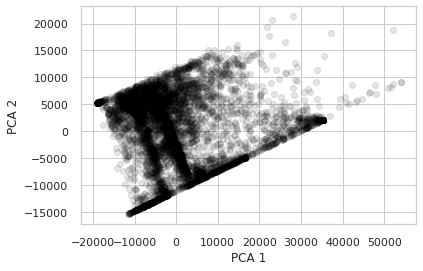

In [389]:
import matplotlib.pyplot as plt
plt.scatter(pf2["PC1"], pf2["PC2"], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

## TS

In [124]:
from fbprophet import Prophet

In [128]:
ts=spark.read.option("header", "true").csv("s3://tryts/ts.csv")

In [129]:
ts.printSchema()

root
 |-- station: string (nullable = true)
 |-- date: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- elevation: string (nullable = true)
 |-- wind: string (nullable = true)
 |-- cig: string (nullable = true)
 |-- vis: string (nullable = true)
 |-- temp: string (nullable = true)
 |-- dew: string (nullable = true)
 |-- slp: string (nullable = true)
 |-- liquid: string (nullable = true)
 |-- liqhr: string (nullable = true)
 |-- month: string (nullable = true)



In [130]:
ts=ts.drop('station')

In [132]:
ts=ts.drop('month')

In [137]:
ts=ts.drop('liqhr')

In [138]:
ts=ts.dropna()

In [139]:
ts.drop('temp').columns

['date',
 'latitude',
 'longitude',
 'elevation',
 'wind',
 'cig',
 'vis',
 'dew',
 'slp',
 'liquid']

In [168]:
colname_float =['liquid', 'latitude', 'dew', 'vis', 'longitude', 'wind', 'elevation', 'cig', 'slp','temp']
colname_timestamp = ["date"]
ts_converted = ts.withColumn("date", ts['date'].cast("timestamp"))
for i in colname_float:
    ts_converted = ts_converted.withColumn(i, ts_converted[i].cast("float"))

ts_converted.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- elevation: float (nullable = true)
 |-- wind: float (nullable = true)
 |-- cig: float (nullable = true)
 |-- vis: float (nullable = true)
 |-- temp: float (nullable = true)
 |-- dew: float (nullable = true)
 |-- slp: float (nullable = true)
 |-- liquid: float (nullable = true)



In [169]:
ts_converted.show(10)

+-------------------+--------+---------+---------+----+-------+-------+----+---+------+------+
|               date|latitude|longitude|elevation|wind|    cig|    vis|temp|dew|   slp|liquid|
+-------------------+--------+---------+---------+----+-------+-------+----+---+------+------+
|2019-01-01 00:00:00|53.22861| 5.760556|     0.91| 8.0|  900.0| 9000.0| 8.2|5.7|1027.8|   0.0|
|2019-01-01 02:00:00|53.22861| 5.760556|     0.91| 9.0| 1500.0|20000.0| 8.4|5.9|1026.8|   0.0|
|2019-01-01 03:00:00|53.22861| 5.760556|     0.91| 9.0|  540.0|17000.0| 8.7|6.2|1026.5|   0.0|
|2019-01-01 06:00:00|53.22861| 5.760556|     0.91| 8.0|  210.0| 3500.0| 8.4|7.9|1025.0|   0.2|
|2019-01-01 09:00:00|53.22861| 5.760556|     0.91| 6.0|  720.0|10000.0| 8.0|5.5|1025.7|   0.0|
|2019-01-01 10:00:00|53.22861| 5.760556|     0.91| 9.0|  930.0|12000.0| 8.0|4.6|1025.8|   0.0|
|2019-01-01 11:00:00|53.22861| 5.760556|     0.91| 9.0|  990.0|13000.0| 8.3|4.5|1026.0|   0.0|
|2019-01-01 12:00:00|53.22861| 5.760556|     0.91|

In [170]:
ts_converted.createOrReplaceTempView("tb")

In [171]:
from pyspark.sql.types import *

In [178]:
sql_statement = '''
  SELECT
    date as ds,
    temp as y
  FROM tb
  ORDER BY ds
  '''

In [179]:
history_pd = spark.sql(sql_statement).cache()

In [180]:
history_pd.printSchema()

root
 |-- ds: timestamp (nullable = true)
 |-- y: float (nullable = true)



In [181]:
history_pd.show(10)

+-------------------+---+
|                 ds|  y|
+-------------------+---+
|2019-01-01 00:00:00|8.2|
|2019-01-01 02:00:00|8.4|
|2019-01-01 03:00:00|8.7|
|2019-01-01 06:00:00|8.4|
|2019-01-01 09:00:00|8.0|
|2019-01-01 10:00:00|8.0|
|2019-01-01 11:00:00|8.3|
|2019-01-01 12:00:00|7.8|
|2019-01-01 13:00:00|7.2|
|2019-01-01 14:00:00|7.2|
+-------------------+---+
only showing top 10 rows



In [187]:
m = Prophet()
m 

In [189]:
# Convert the Spark DataFrame back to a pandas DataFrame using Arrow
result_pd = history_pd.select("*").toPandas()

In [190]:
result_pd

ds    y
0    2019-01-01 00:00:00  8.2
1    2019-01-01 02:00:00  8.4
2    2019-01-01 03:00:00  8.7
3    2019-01-01 06:00:00  8.4
4    2019-01-01 09:00:00  8.0
...                  ...  ...
4399 2019-12-25 05:00:00  6.2
4400 2019-12-25 09:00:00  6.5
4401 2019-12-25 12:00:00  8.0
4402 2019-12-25 15:00:00  7.2
4403 2019-12-31 00:00:00  7.7

[4404 rows x 2 columns]

In [192]:
model = Prophet(
  interval_width=0.95,
  growth='linear',
  daily_seasonality=False,
  weekly_seasonality=True,
  yearly_seasonality=True,
  seasonality_mode='multiplicative'
  )

In [193]:
model.fit(result_pd)

In [194]:
future_pd = model.make_future_dataframe(
  periods=10, 
  freq='d', 
  include_history=True
  )

# predict over the dataset
forecast_pd = model.predict(future_pd)

display(forecast_pd)

ds      trend  yhat_lower  yhat_upper  trend_lower  \
0    2019-01-01 00:00:00  10.928045    1.368430   13.442396    10.928045   
1    2019-01-01 02:00:00  10.927974    1.439252   13.627534    10.927974   
2    2019-01-01 03:00:00  10.927938    1.584881   13.474228    10.927938   
3    2019-01-01 06:00:00  10.927832    1.189072   13.447357    10.927832   
4    2019-01-01 09:00:00  10.927726    1.267003   13.173314    10.927726   
...                  ...        ...         ...         ...          ...   
4409 2020-01-06 00:00:00  10.499678   -0.003828   13.513374    10.499498   
4410 2020-01-07 00:00:00  10.498144    0.159376   12.565131    10.497915   
4411 2020-01-08 00:00:00  10.496610    0.034104   12.322325    10.496338   
4412 2020-01-09 00:00:00  10.495077   -0.389898   11.881901    10.494743   
4413 2020-01-10 00:00:00  10.493543   -0.988280   11.320842    10.493159   

      trend_upper  multiplicative_terms  multiplicative_terms_lower  \
0       10.928045             -0.320865                   -0.320865   
1       10.927974             -0.320100                   -0.320100   
2       10.927938             -0.319619                   -0.319619   
3       10.927832             -0.317924                   -0.317924   
4       10.927726             -0.316114                   -0.316114   
...           ...                   ...                         ...   
4409    10.499841             -0.368465                   -0.368465   
4410    10.498345             -0.413060                   -0.413060   
4411    10.496851             -0.423075                   -0.423075   
4412    10.495369             -0.464732                   -0.464732   
4413    10.493901             -0.506118                   -0.506118   

      multiplicative_terms_upper    weekly  weekly_lower  weekly_upper  \
0                      -0.320865 -0.009287     -0.009287     -0.009287   
1                      -0.320100 -0.007883     -0.007883     -0.007883   
2                      -0.319619 -0.007074     -0.007074     -0.007074   
3                      -0.317924 -0.004367     -0.004367     -0.004367   
4                      -0.316114 -0.001499     -0.001499     -0.001499   
...                          ...       ...           ...           ...   
4409                   -0.368465  0.012421      0.012421      0.012421   
4410                   -0.413060 -0.009287     -0.009287     -0.009287   
4411                   -0.423075  0.006155      0.006155      0.006155   
4412                   -0.464732 -0.007728     -0.007728     -0.007728   
4413                   -0.506118 -0.019330     -0.019330     -0.019330   

        yearly  yearly_lower  yearly_upper  additive_terms  \
0    -0.311578     -0.311578     -0.311578             0.0   
1    -0.312218     -0.312218     -0.312218             0.0   
2    -0.312545     -0.312545     -0.312545             0.0   
3    -0.313557     -0.313557     -0.313557             0.0   
4    -0.314616     -0.314616     -0.314616             0.0   
...        ...           ...           ...             ...   
4409 -0.380886     -0.380886     -0.380886             0.0   
4410 -0.403773     -0.403773     -0.403773             0.0   
4411 -0.429231     -0.429231     -0.429231             0.0   
4412 -0.457004     -0.457004     -0.457004             0.0   
4413 -0.486787     -0.486787     -0.486787             0.0   

      additive_terms_lower  additive_terms_upper      yhat  
0                      0.0                   0.0  7.421619  
1                      0.0                   0.0  7.429925  
2                      0.0                   0.0  7.435163  
3                      0.0                   0.0  7.453612  
4                      0.0                   0.0  7.473317  
...                    ...                   ...       ...  
4409                   0.0                   0.0  6.630914  
4410                   0.0                   0.0  6.161780  
4411                   0.0                   0.0  6.055756  
4412        

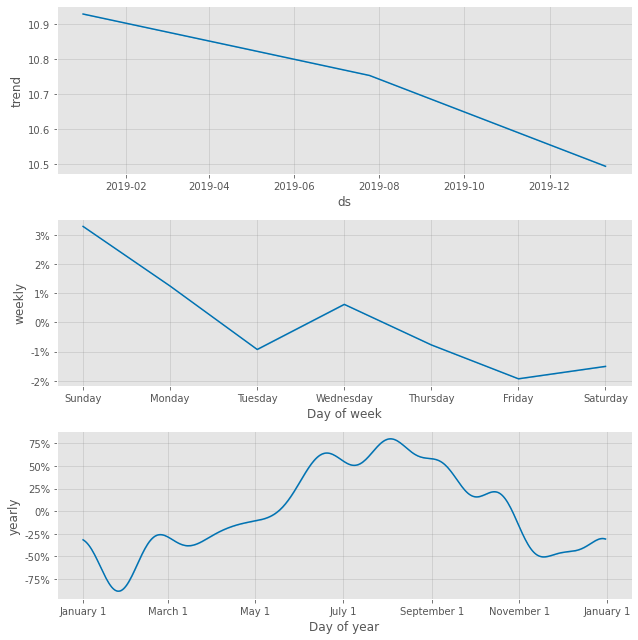

In [198]:
trends_fig = model.plot_components(forecast_pd)
#display(trends_fig)

In [199]:
predict_fig = model.plot( forecast_pd, xlabel='date', ylabel='temp')

# adjust figure to display dates from last year + the 90 day forecast
xlim = predict_fig.axes[0].get_xlim()
new_xlim = ( xlim[1]-(180.0+365.0), xlim[1]-10.0)
predict_fig.axes[0].set_xlim(new_xlim)

#display(predict_fig)

(736907.7, 737442.7)

In [19]:
sc.stop()